<a href="https://colab.research.google.com/github/GARAM-SHIN/2025-1_CV/blob/main/HW%233.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lecture 3 : Deep Learning Vision**


## **공통 코드**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

## **[실험 A] 손실 함수 비교 : CrossEntropy Loss vs MSE Loss (with softmax)**


In [2]:
# 실험의 일관성을 위한 시드 설정 : 모든 난수 동기화
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# GPU 사용 가능 여부 설정 : 가능할 시 GPU 사용, 불가능할 시 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Fashion-MNIST 데이터셋 로딩 및 전처리 : 정규화된 텐서 형태로 변환
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 20.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 331kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.11MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.29MB/s]


In [5]:
# 데이터로더를 통해 학습 데이터와 테스트 데이터를 배치 단위로 불러오기
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
# 은닉층 2개, 출력층 1개로 구성된 다층 퍼셉트론 모델 정의
class MLP(nn.Module):
    def __init__(self, activation_fn):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.act1 = activation_fn    # 첫 번째 활성화 함수
        self.fc2 = nn.Linear(256, 128)
        self.act2 = activation_fn    # 두 번째 활성화 함수
        self.fc3 = nn.Linear(128, 10)    # 출력층

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.act1(self.fc1(x))    # 은닉층 연산 및 활성화  함수 적용
        x = self.act2(self.fc2(x))
        x = self.fc3(x)
        return x    # 출력층 결과 반환

In [7]:
# 테스트 데이터에 대한 정확도 평가
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():    # 그레디언트 계산 비활성화로 인한 속도 향상
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            pred = outputs.argmax(dim=1)    # 확률이 가장 높은 클래스 선택
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total    # 정확도 계산

In [8]:
# 손실 함수 선택에 따른 학습 함수 정의
def train_model(loss_type="crossentropy", epochs=30):
    model = MLP(nn.ReLU()).to(device)

    # 손실 함수와 옵티마이저 설정
    if loss_type == "mse":    # MSE Loss
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.05)
    else:    # CrossEntropy
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.05)

    train_losses, test_accuracies = [], []

    for epoch in range(epochs):    # 에포크 수만큼 학습 반복
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)

            if loss_type == "mse":   # MSE 손실 함수는 softmax와 one-hot으로 변환
                outputs = F.softmax(outputs, dim=1)
                y_onehot = F.one_hot(y, num_classes=10).float()    # 확률 변환
                loss = criterion(outputs, y_onehot)
            else:
                loss = criterion(outputs, y)

            loss.backward()     # 역전파로 그레디언트 계산
            optimizer.step()    # 가중치 업데이트
            running_loss += loss.item()

        # 에포크별 평균 손실 및 정확도 저장
        avg_loss = running_loss / len(train_loader)
        acc = evaluate(model, test_loader)
        train_losses.append(avg_loss)
        test_accuracies.append(acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {acc:.4f}")

    return train_losses, test_accuracies

In [9]:
# 손실 및 정확도 그래프 시각화
def plot_metrics(loss1, acc1, loss2, acc2):
    epochs = range(1, len(loss1)+1)
    plt.figure(figsize=(14, 6))

    # 손실 (Loss) 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss1, label="CrossEntropy Loss")
    plt.plot(epochs, loss2, label="MSE Loss + Softmax")
    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc1, label="CrossEntropy Accuracy")
    plt.plot(epochs, acc2, label="MSE Accuracy")
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
# MSE와 CrossEntropy 실험 실행
loss_ce, acc_ce = train_model(loss_type="crossentropy")
loss_mse, acc_mse = train_model(loss_type="mse")

Epoch 1/30 | Loss: 0.8029 | Accuracy: 0.7942
Epoch 2/30 | Loss: 0.4847 | Accuracy: 0.8086
Epoch 3/30 | Loss: 0.4259 | Accuracy: 0.8431
Epoch 4/30 | Loss: 0.3916 | Accuracy: 0.8250
Epoch 5/30 | Loss: 0.3680 | Accuracy: 0.8493
Epoch 6/30 | Loss: 0.3485 | Accuracy: 0.8588
Epoch 7/30 | Loss: 0.3336 | Accuracy: 0.8589
Epoch 8/30 | Loss: 0.3214 | Accuracy: 0.8640
Epoch 9/30 | Loss: 0.3105 | Accuracy: 0.8703
Epoch 10/30 | Loss: 0.3001 | Accuracy: 0.8669
Epoch 11/30 | Loss: 0.2907 | Accuracy: 0.8636
Epoch 12/30 | Loss: 0.2821 | Accuracy: 0.8722
Epoch 13/30 | Loss: 0.2754 | Accuracy: 0.8672
Epoch 14/30 | Loss: 0.2676 | Accuracy: 0.8737
Epoch 15/30 | Loss: 0.2620 | Accuracy: 0.8799
Epoch 16/30 | Loss: 0.2538 | Accuracy: 0.8730
Epoch 17/30 | Loss: 0.2486 | Accuracy: 0.8792
Epoch 18/30 | Loss: 0.2418 | Accuracy: 0.8858
Epoch 19/30 | Loss: 0.2354 | Accuracy: 0.8836
Epoch 20/30 | Loss: 0.2301 | Accuracy: 0.8883
Epoch 21/30 | Loss: 0.2259 | Accuracy: 0.8865
Epoch 22/30 | Loss: 0.2212 | Accuracy: 0.88

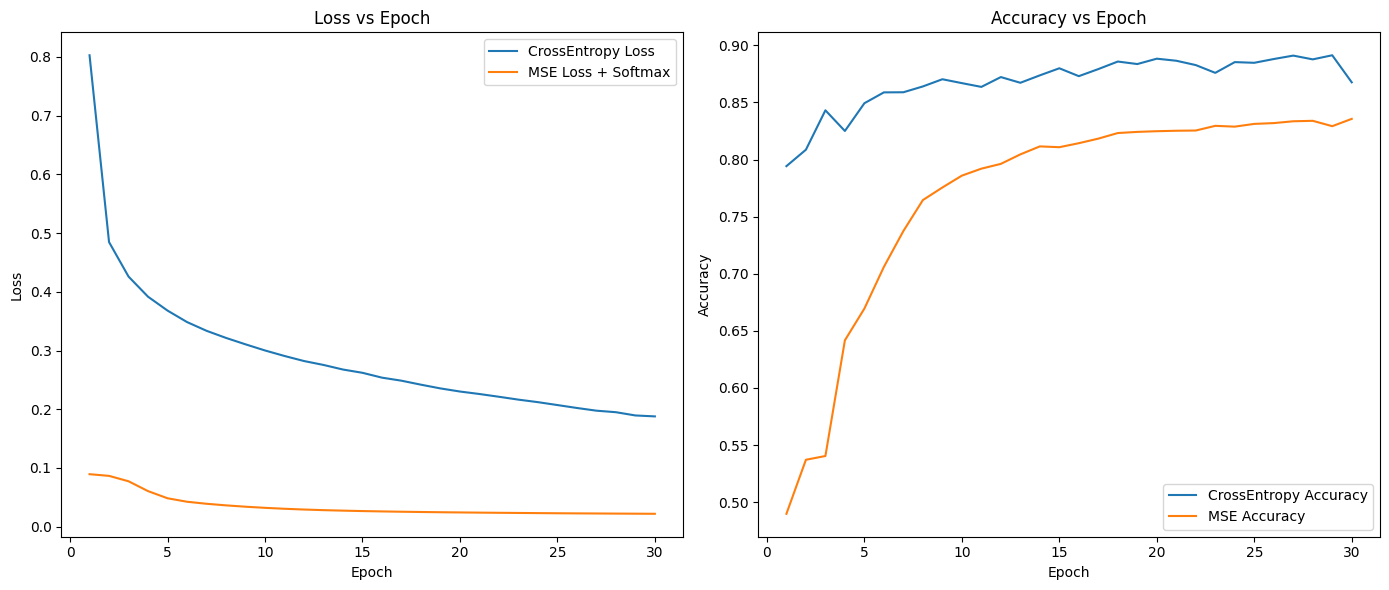

In [11]:
# 실험 시각화
plot_metrics(loss_ce, acc_ce, loss_mse, acc_mse)

## **[실험 B] 활성화 함수 비교 : ReLU vs LeakyReLU vs Sigmoid**

In [13]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

In [5]:
class DebugMLP(nn.Module):
    def __init__(self, activation_fn):
        super(DebugMLP, self).__init__()
        self.activation_fn = activation_fn
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        self.z1 = self.fc1(x)
        self.a1 = self.activation_fn(self.z1)
        self.z2 = self.fc2(self.a1)
        self.a2 = self.activation_fn(self.z2)
        return self.fc3(self.a2)

In [6]:
def plot_histogram_activations(a1, a2, title):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.hist(a1.detach().numpy().flatten(), bins=50, color='skyblue', edgecolor='black')
    plt.title(f"{title} - Layer 1 Activations")
    plt.subplot(1, 2, 2)
    plt.hist(a2.detach().numpy().flatten(), bins=50, color='salmon', edgecolor='black')
    plt.title(f"{title} - Layer 2 Activations")
    plt.tight_layout()
    plt.show()

In [7]:
def compute_dead_ratio(activation):
    dead = torch.sum(activation == 0, dim=0).float()
    return (dead / activation.size(0)).numpy()

In [8]:
def plot_heatmap(data, title):
    plt.figure(figsize=(10, 2))
    sns.heatmap(data[np.newaxis, :], cmap="Reds", cbar=True, xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel("Neuron Index")
    plt.tight_layout()
    plt.show()

In [9]:
def plot_gradient_flow(grads, title):
    plt.figure(figsize=(10, 4))
    for name, grad in grads.items():
        plt.plot(grad, label=name)
    plt.title(f"Gradient Flow - {title}")
    plt.xlabel("Neuron Index")
    plt.ylabel("Gradient Magnitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
activations = {
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(0.01),
    "Sigmoid": nn.Sigmoid()
}

In [11]:
criterion = nn.CrossEntropyLoss()

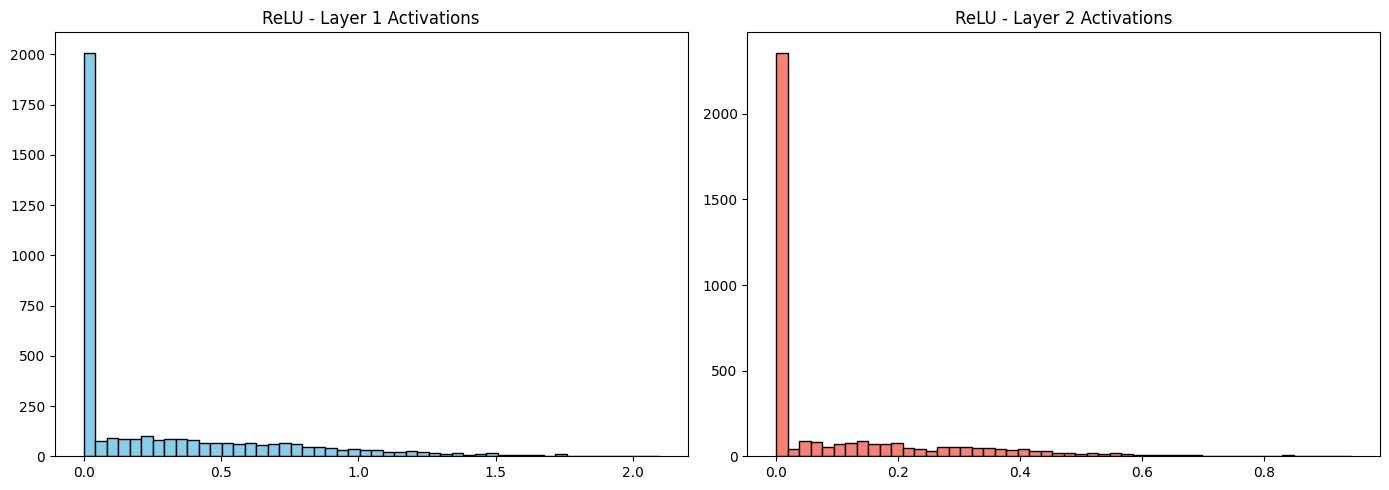

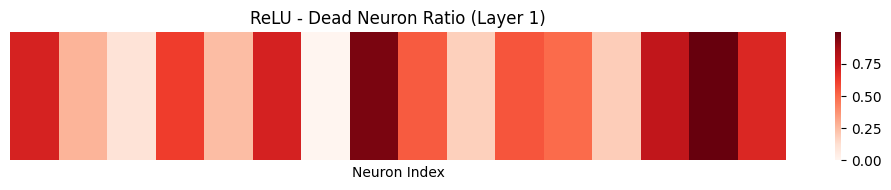

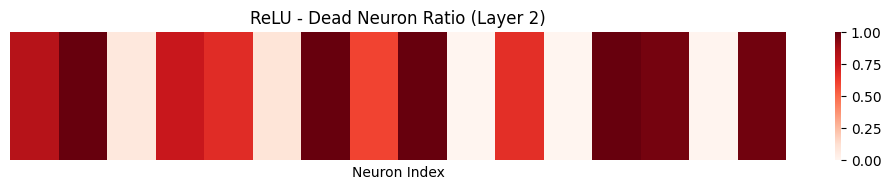

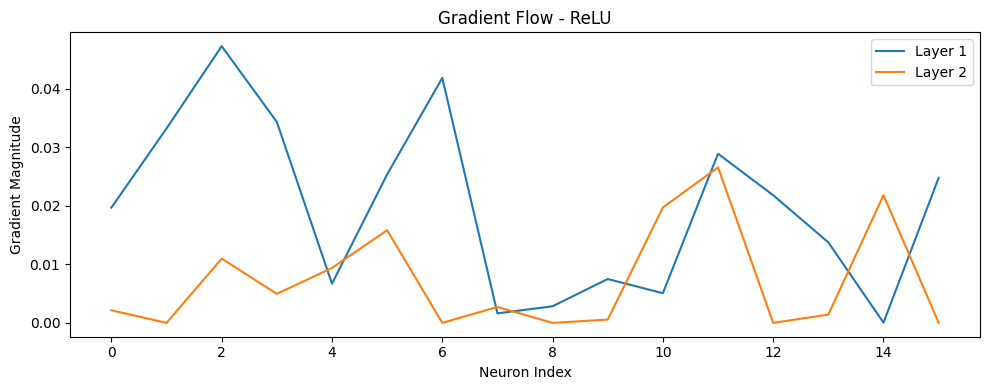

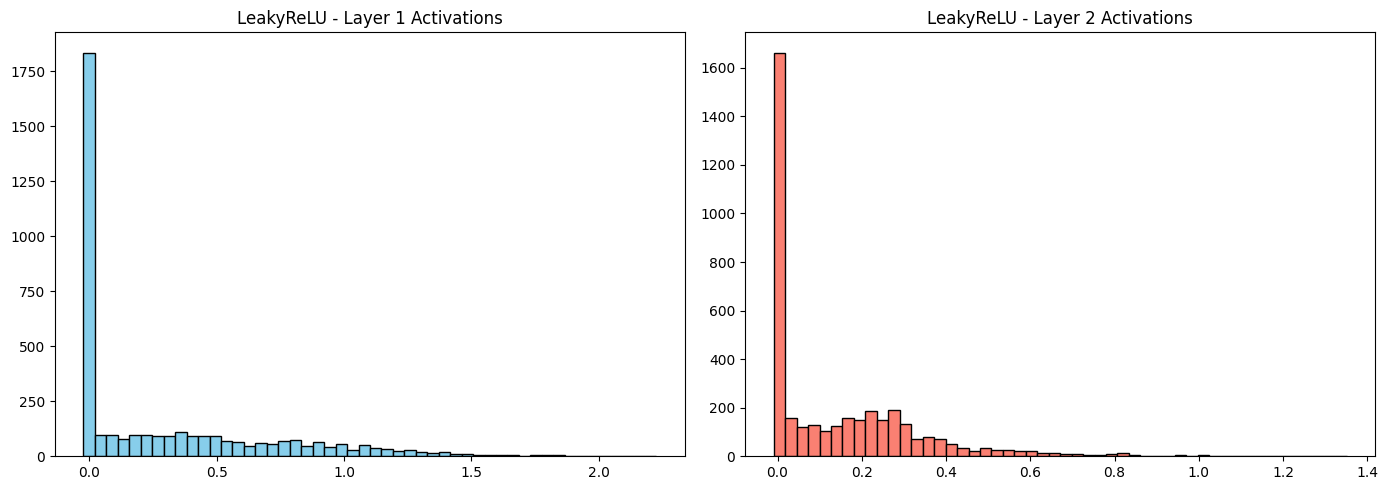

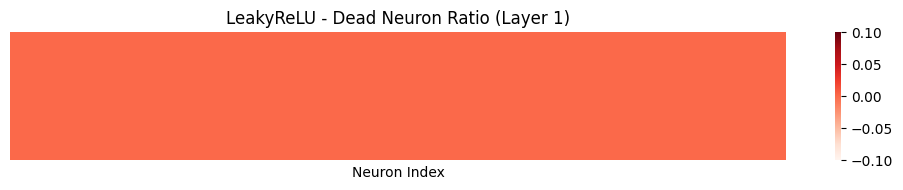

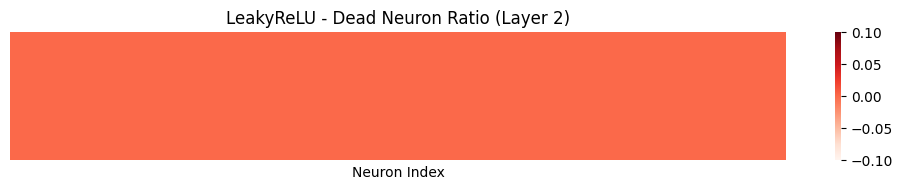

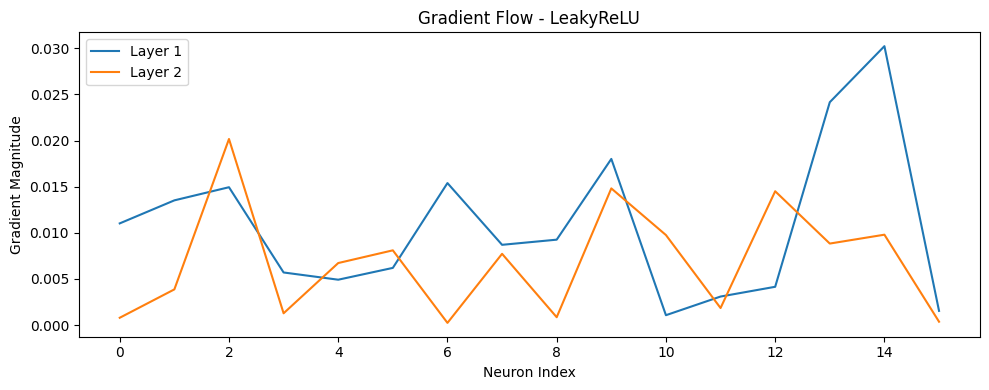

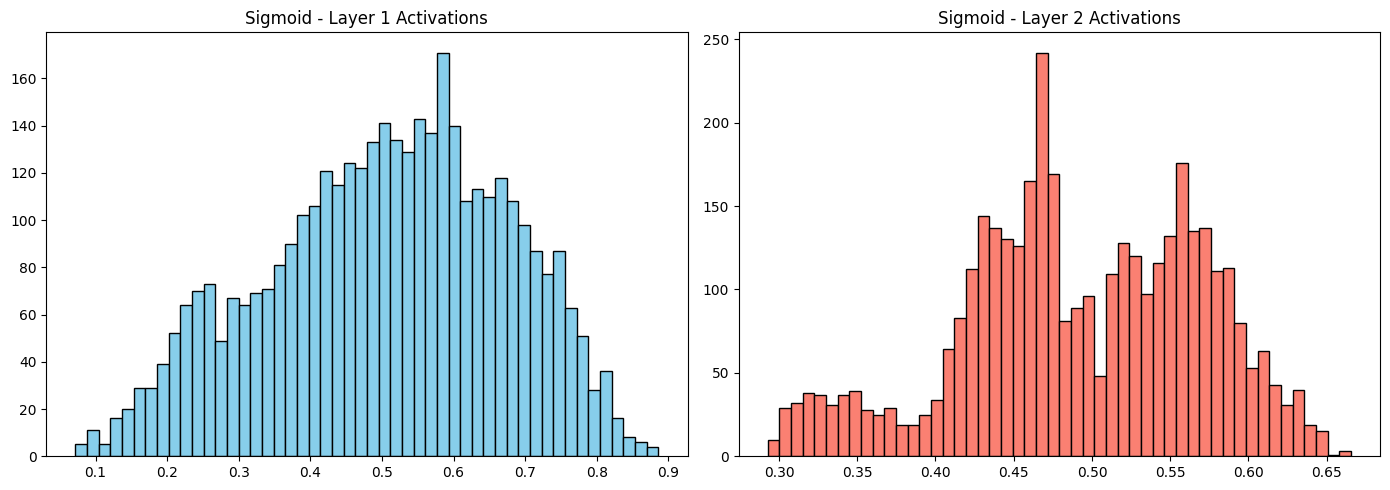

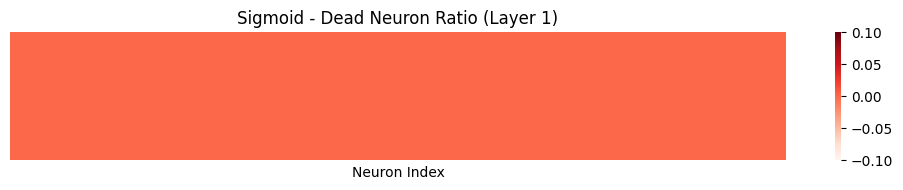

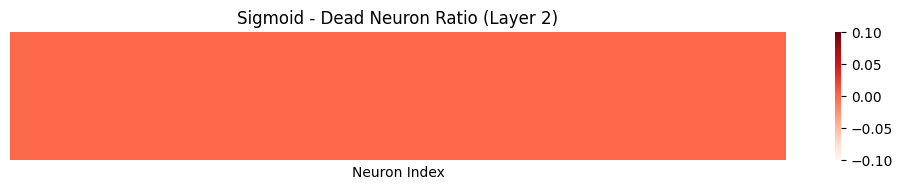

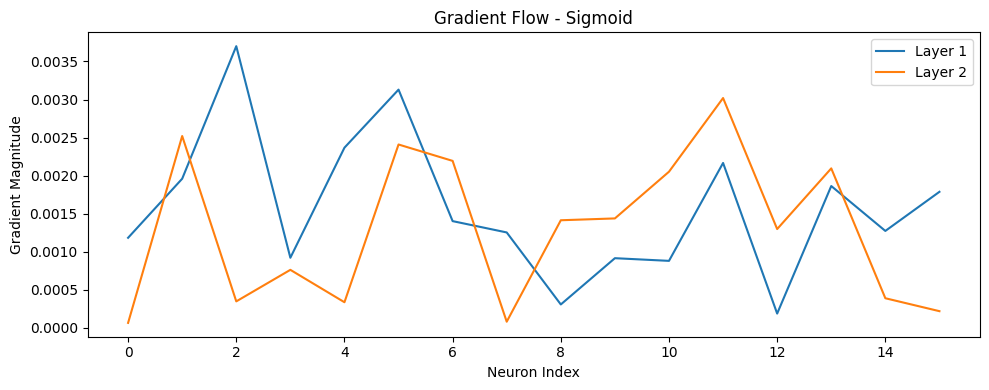

In [14]:
for name, act_fn in activations.items():
    model = DebugMLP(act_fn)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()

    plot_histogram_activations(model.a1, model.a2, name)

    plot_heatmap(compute_dead_ratio(model.a1), f"{name} - Dead Neuron Ratio (Layer 1)")
    plot_heatmap(compute_dead_ratio(model.a2), f"{name} - Dead Neuron Ratio (Layer 2)")

    grads = {
        "Layer 1": model.fc1.weight.grad.abs().mean(dim=1).detach().numpy(),
        "Layer 2": model.fc2.weight.grad.abs().mean(dim=1).detach().numpy(),
    }
    plot_gradient_flow(grads, name)

## **[실험 C] 최적화 알고리즘 비교 : SGD, SGD+Momentum, Adam**

In [26]:
# 실험의 일관성을 위한 시드 설정 : 모든 난수 동기화
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [27]:
# GPU 사용 가능 여부 설정 : 가능할 시 GPU 사용, 불가능할 시 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# Fashion-MNIST 데이터셋 로딩 및 전처리 : 정규화된 텐서 형태로 변환
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

In [29]:
# 데이터로더를 통해 학습 데이터와 테스트 데이터를 배치 단위로 불러오기
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [30]:
# 은닉층 2개, 출력층 1개로 구성된 다층 퍼셉트론 모델 정의
class MLP(nn.Module):
    def __init__(self, activation_fn):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.act1 = activation_fn    # 첫 번째 활성화 함수
        self.fc2 = nn.Linear(256, 128)
        self.act2 = activation_fn    # 두 번째 활성화 함수
        self.fc3 = nn.Linear(128, 10)    # 출력층

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.act1(self.fc1(x))    # 은닉층 연산 및 활성화 함수 적용
        x = self.act2(self.fc2(x))
        x = self.fc3(x)
        return x    # 출력층 결과 반환

In [31]:
# 최적화 알고리즘에 따른 학습
def train_model_c(optimizer_name, lr, epochs=30):
    model = MLP(nn.ReLU()).to(device)    # ReLU로 모델 생성
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "sgd":    # 최적화 설정 : SGD
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "momentum":    # 최적화 설정 : SGD + Momentum
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:    # 최적화 설정 : Adam
        optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)    # 학습률 감소

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):    # 에포크 수만큼 학습 반복
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 에포크 종료 후 손실 및 정확도 결과 기록
        avg_loss = running_loss / len(train_loader)
        acc = evaluate(model, test_loader)
        train_losses.append(avg_loss)
        test_accuracies.append(acc)

        scheduler.step()    # 에포크마다 학습률 감소

    return train_losses, test_accuracies

In [32]:
# 최적화 기법 결과 시각화
def plot_experiment_c(results_dict):
    epochs = range(1, len(next(iter(results_dict.values()))[0]) + 1)
    plt.figure(figsize=(14, 6))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    for k, (losses, _) in results_dict.items():
        plt.plot(epochs, losses, label=f"{k} - Loss")
    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    for k, (_, accs) in results_dict.items():
        plt.plot(epochs, accs, label=f"{k} - Accuracy")
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

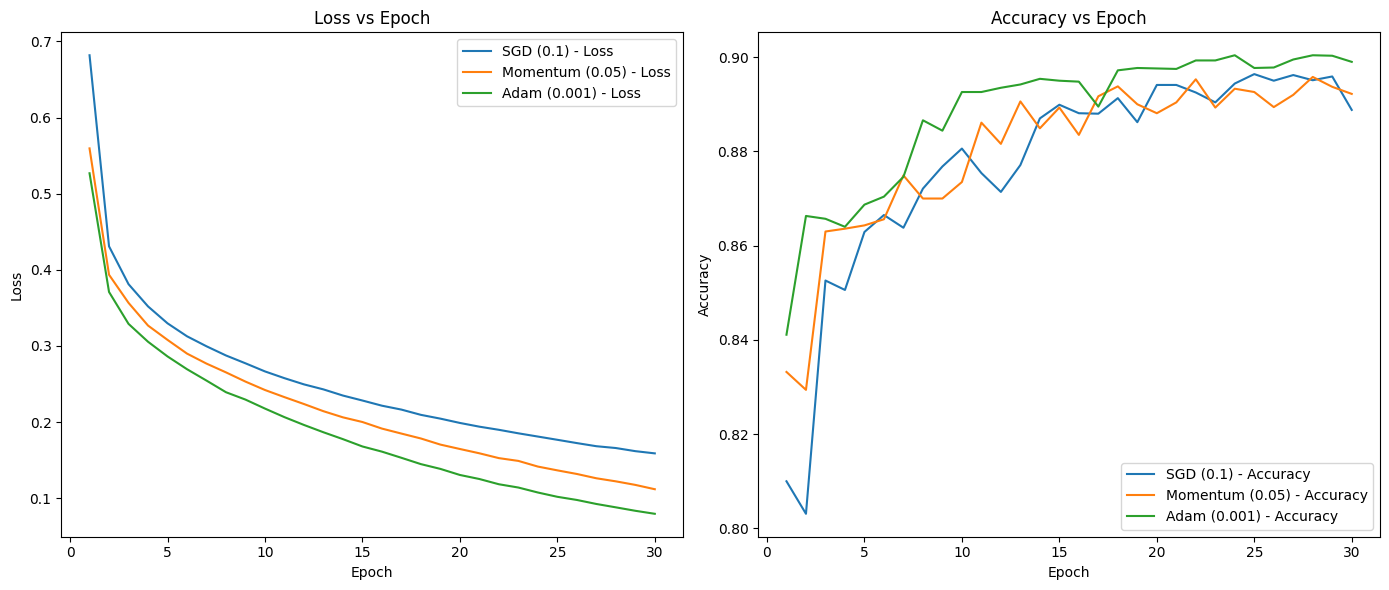

In [33]:
# 최적화 기법별 학습 실행
results_c = {
    'SGD (0.1)': train_model_c('sgd', lr=0.1),
    'Momentum (0.05)': train_model_c('momentum', lr=0.05),
    'Adam (0.001)': train_model_c('adam', lr=0.001)
}

# 최적화 기법별 결과 시각화
plot_experiment_c(results_c)